# Simulating data with ironman

In this tutorial, we will see how to simulate RM data with the objective of include it in our proposals. First thing we need is to import ironman

In [1]:
import ironman
import numpy as np
import matplotlib.pyplot as plt

Then, we need to create a dictionary with the properties of the system we want to to observe. Lets take the case of TOI-3362b. Assuming a well-aligned orbit we have:

In [2]:
dct_system = {"per_p1":18.09537,
       "aRs_p1":19.01,
       "inc_p1":84.25,
       "vsini_star":20.2,
       "p_p1":0.069,
       "rv_prec":10.,
       "exp_time":300,
       "e_p1":0.72,
       "omega_p1":60.5,
       "beta":7.6,
       "lam_p1":1.2,
       "t0_p1":2458529.32785,
       "u":[0.32694400,0.33127792]}

Where we also assumed an exposure time of 300s and an RV presicion of 10 m/s. Also to simulate the data we added the instrumental and macroturbulence broadening of the spectral lines in quadrature to have an idea of the beta parameter. 

Once the properties of the system are defined, we have to find the transit windows. In our case we know a window transit for the planet
on Dec 27, 2022. Converting that to BJD:

In [3]:
from astropy.time import Time

tr_window = ['2022-12-27T03:00:00', '2022-12-27T09:00:00']
tr_window = Time(tr_window, format='isot', scale='utc')
print(tr_window.jd)

[2459940.625 2459940.875]


So observations must be performed between those times. Now lets create our observation times assuming 300s exposure time.

In [4]:
bjd = np.arange(2459940.625,2459940.875,300.0/60.0/60.0/24.0)

And finally, lets simulate the data and plot it!

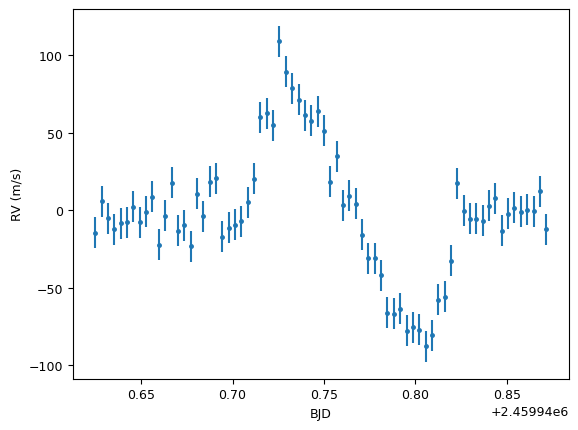

In [5]:
sim_data, error = ironman.create_RM_data(bjd,dct_system)

plt.errorbar(bjd,sim_data,error,fmt=".")
plt.xlabel("BJD")
plt.ylabel("RV (m/s)")
plt.show()

To see how well we can constrain the sky-projected obliquity using the simulated data we only have to input it into the ironman DataOrg and follow the same steps than for the real data.

In [6]:
times_lc, fluxes, fluxes_error = {}, {}, {}
times_rvs, rvs, rvs_err =  {}, {}, {}
times_RM, RM, RM_err =  {}, {}, {}

times_RM["ESPRESSO"], RM["ESPRESSO"], RM_err["ESPRESSO"] = bjd, sim_data, error

exp_times = {"ESPRESSO": 300.0/60.0/60.0/24.0}

In [7]:
my_data = ironman.Data_Org(lc_time=times_lc,lc_flux=fluxes,lc_flux_err=fluxes_error,rv_time=times_rvs,rv=rvs,rv_err=rvs_err,rm_time=times_RM,rm=RM,rm_err=RM_err,verbose = True,exp_times=exp_times)

Reading LCs...
Reading RVs...
Reading RM data...


In [8]:
my_priors = ironman.Priors("Example2_priors.dat",my_data)

Priors dictionary ready...
Detecting fixed parameters...
Fixed K_p1 detected!
Fixed sigma_ESPRESSO detected!
Fixed gammadot detected!
Fixed gammadotdot detected!


In [9]:
my_fit = ironman.Fit(my_data,my_priors)

In [10]:
post_samples = my_fit.run(n_live=500, nthreads = 24)

Running dynesty with 500 nlive and 24 threads


16329it [00:57, 282.07it/s, batch: 5 | bound: 27 | nc: 1 | ncall: 472741 | eff(%):  3.341 | loglstar: -211.398 < -204.637 < -206.058 | logz: -218.371 +/-  0.112 | stop:  0.966]      


In [11]:
my_post = ironman.Post(my_data,my_priors,my_fit,post_samples)

lam_p1 -0.39136347321945664 1.957802906503474 1.909594526185458
vsini_star 20.573901279567117 1.2864474356953934 1.4363458342474864
per_p1 18.095364966234893 8.80021162785738e-06 8.785429290725233e-06
t0_p1 2458529.327618544 0.000609569251537323 0.0006015971302986145
rho_star 400.15356651087114 16.253262316320217 16.346892064746953
b_p1 0.5684093882418491 0.04058566522206053 0.03776649363706497
p_p1 0.0699781068440094 0.0010012981499076395 0.0009954020335268404
e_p1 0.7215157083802238 0.013457215755151464 0.012645694913032135
omega_p1 60.72044624260187 6.75951529496664 6.899917240237585
q1_ESPRESSO 0.41101141405064173 0.21577500288329282 0.3042453415150859
q2_ESPRESSO 0.24319446807737574 0.17863799438416822 0.3138670813979194
beta_ESPRESSO 8.275696051415178 1.8609816785398268 1.934530661113449
gamma_ESPRESSO -2.316047715056839 1.4264524765882851 1.4675680953772154
aRs_p1: 19.062262415636965 0.2616637303596754 0.2561239467723624
inc_p1: 84.2075569909478 0.3281037880224602 0.344565746175

In the simulation we get an errorbar of 2 deg for lambda!

In [12]:
times_espresso = my_post.data.x["ESPRESSO"]
times_models_espresso = np.linspace(times_espresso[0],times_espresso[-1],5000)
rm_model, rm_models = my_post.evaluate_RM_model(times_models_espresso,"ESPRESSO",models=True,number_models=5000)
rm_model_obs = my_post.evaluate_RM_model(times_espresso,"ESPRESSO",models=False)

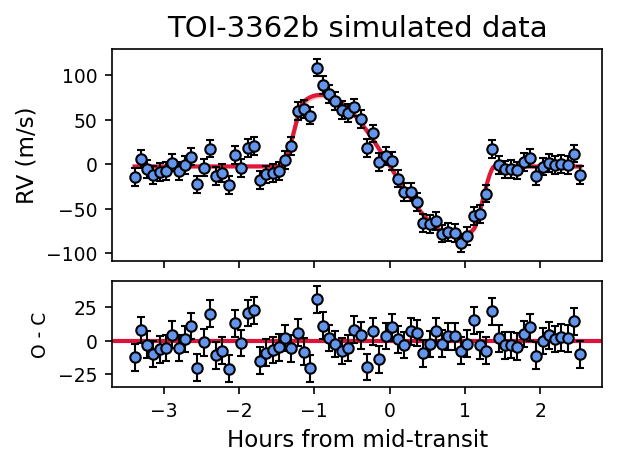

In [13]:
fig = plt.figure(figsize=(4,3),dpi=150,constrained_layout=True)

gs = fig.add_gridspec(3, 6)
ax1 = fig.add_subplot(gs[:2, :])
ax2 = fig.add_subplot(gs[2, :], sharex = ax1)

t0 = my_post.vals["t0_p1"]
P = my_post.vals["per_p1"]

times_model_plot = (times_models_espresso-t0-78*P)*24.
times, data, error = my_post.data.x["ESPRESSO"],my_post.data.y["ESPRESSO"],my_post.data.yerr["ESPRESSO"]
times = (times-t0-78*P)*24.
ax1.plot(times_model_plot,rm_model,lw=2,color="crimson",zorder=-10)
ax1.fill_between(times_model_plot,np.quantile(rm_models,0.16,axis=0),np.quantile(rm_models,0.84,axis=0),alpha=0.3,color="#EE2C2C",lw=0,zorder=-1)
ax1.errorbar(times,data,error,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="cornflowerblue")
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel('RV (m/s)',fontsize=11)
ax1.set_title("TOI-3362b simulated data", fontsize=14)

res = data-rm_model_obs
ax2.errorbar(times,res,error,fmt="o",color="k",capsize=2,elinewidth=1,markerfacecolor="cornflowerblue")
ax2.axhline(0.0,lw=2,color="crimson",zorder=-10)
#ax2.set_ylim(-15,15)
#ax2.set_xticks([-3,-2,-1,0,1,2])
ax2.set_xlabel(r'Hours from mid-transit',fontsize=11)
ax2.set_ylabel('O - C')

plt.show()